# Import Libraries

In [1]:
from fairlearn.metrics import (
    MetricFrame,
    count
)
import numpy as np
import pandas as pd

In [129]:
from jiwer import wer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Speech-to-Text Fairness Assessment

In this notebook, we walk through a scenario of assessing a *speech-to-text* service for fairness-related disparities. For this fairness assessment, we consider various `sensitive features`, such as `native language`, `sex`, and `country` where the speaker is located. 

For this audit, we will be working with a CSV file `stt_testing_data.csv` that contains 2138 speech samples. Each row in the dataset represents a person reading a particular reading passage in English. A machine system is used to generate a transcription from the audio of person reading the passage.

If you wish to run this notebook with your speech data, you can use the `run_stt.py` provided to query the Microsoft Cognitive Service Speech API. You can also run this notebook with a dataset generated from other speech-to-text systems.

In [4]:
stt_results_csv = "stt_testing_data.csv"

In this dataset, `ground_truth_text` represents the English passage the participant was asked to read. `predicted_text` represents the transcription produced by the automated service. We will also look at demographic features, such as `sex` of the participant and the `country` where the participant is located.

In [5]:
df = pd.read_csv(f"{stt_results_csv}",
                usecols=["age", "native_language", "sex", "country", "ground_truth_text", "predicted_text"]
                )

In [6]:
df.shape

(2138, 6)

The goal of a fairness assessment is to *understand which groups of people may be disproportionately negatively impacted by an AI system and in which ways*?

For our fairness assessment, we perform the following tasks:

1. Idenfity harms and which groups may be harmed.

2. Define fairness metrics to quantify harms

3. Compare our quantified harms across the relevant groups.

## 1.) Identify Harms and groups who may be harmed

The first step of the fairness assessment is identifying the types of fairness-related harms we expect users of the systems to experience. From the harms taxonomy in the [Fairlearn User Guide]( https://fairlearn.org/v0.7.0/user_guide/fairness_in_machine_learning.html#types-of-harms), we expect our *speech-to-text* system produces *quality of service* harms to users. 

*Quality-of-service* harms occur when an AI system does not work as well for one person as it does for others, even when no resources or opportunities are withheld.

There have been several studies demonstrating that speech-to-text systems achieve different levels of performance based on the speaker's gender and language dialect (Add link to papers). In this assessment, we will explore how the performance of our speech-to-text system differs based on language dialect (proxied by `country`) and `sex` for speakers in three English-speaking countries.

In [7]:
sensitive_country = ["country"]
sensitive_country_sex = ["country", "sex"]

In [8]:
countries = ["usa", "uk", "canada"]
filtered_df = df.query(f"country in {countries} and native_language == 'english'")

In [9]:
filtered_df.head()

,age,native_language,sex,country,ground_truth_text,predicted_text
331,42.0,english,male,usa,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...
332,35.0,english,female,usa,Please call Stella. Ask her to bring these th...,Please call Stella asked her to bring these th...
333,23.0,english,female,usa,Please call Stella. Ask her to bring these th...,Please call Stella Hasker to bring these thing...
334,18.0,english,female,canada,Please call Stella. Ask her to bring these th...,Please call Stella asked her to bring these th...
335,22.0,english,male,usa,Please call Stella. Ask her to bring these th...,Please call Stella asked her to bring these th...


One challenge for our fairness assessment is the small group sample sizes. Our filtered dataset consists primarily of English speakers in the USA, so we expect higher uncertainty for our metrics on speakers from the other two countries. The smaller sample sizes for *UK* and *Canadian* speakers means we may not be able to find significant differences once we also account for `sex`.

In [10]:
display(filtered_df.groupby(["country"])["sex"].count())

country
canada     44
uk         65
usa       373
Name: sex, dtype: int64

## 2.) Define fairness metrics to quantify harms

To measure differences in performance, we will be looking at the `word_error_rate`. The `word_error_rate` represented the fraction of words that are transcribed incorrectly compared to a ground truth text. A higher `word_error_rate` reflects that the system achieves worse performance for a particular group.

Compared to the human transcription (what speaker said is different to ground truth text).

In [11]:
DISPARITY_BASE = 0.5

def word_error_rate(y_true, y_pred):
    return wer(str(y_true), str(y_pred))

def wer_abs_disparity(y_true, y_pred, disparity=DISPARITY_BASE):
    return (word_error_rate(y_true, y_pred) - disparity)
    
def wer_rel_disparity(y_true, y_pred, disparity=DISPARITY_BASE):
    return wer_abs_disparity(y_true, y_pred, disparity)/disparity

WER as a disparity from some base. Might be better to compute maximal difference between groups.

In [12]:
fairness_metrics = {
    "count": count,
    "word_error_rate": word_error_rate,
    "word_error_rate_abs_disparity": wer_abs_disparity,
    "word_error_rate_rel_disparity": wer_rel_disparity
}

## 3.) Compare quantifed harms across different groups

In the final part of our fairness assessment, we use the `MetricFrame` object in the `fairlearn` package to compare our system's performance across our `sensitive features`.

To instanstiate a `MetricFrame`, we pass in four parameters:
- `metrics`: The `fairness_metrics` to evaluate each group on.
- `y_true`: The `ground_truth_text`
- `y_pred`: The `predicted_text`
- `sensitive_features`: Our groups for fairness assessment

For our first analysis, we look at the system's performance with repsect to `country`.

In [13]:
metricframe_country = MetricFrame(
    metrics=fairness_metrics,
    y_true=filtered_df.loc[:, "ground_truth_text"],
    y_pred=filtered_df.loc[:, "predicted_text"],
    sensitive_features=filtered_df.loc[:, sensitive_country]
)

Using the `MetricFrame`, we can easily compute the `word_error_rate differences` between our three countries.

In [14]:
display(metricframe_country.by_group[["count", "word_error_rate"]])
display(metricframe_country.difference())

,count,word_error_rate
country,,
canada,44,0.339262
uk,65,0.394649
usa,373,0.344446


count                                 329
word_error_rate                  0.055387
word_error_rate_abs_disparity    0.055387
word_error_rate_rel_disparity    0.110773
dtype: object

We see the maximal `word_error_rate difference` (between`UK` and `Canada`) is 0.05. Since the `MetricFrame` is built on top of the `Pandas DataFrame` object, we can take advantage of `Pandas`'s plotting capabilities to visualize the `word_error_rate` by `country`.

<AxesSubplot:title={'center':'Word Error Rate by Country'}, xlabel='country', ylabel='Word Error Rate'>

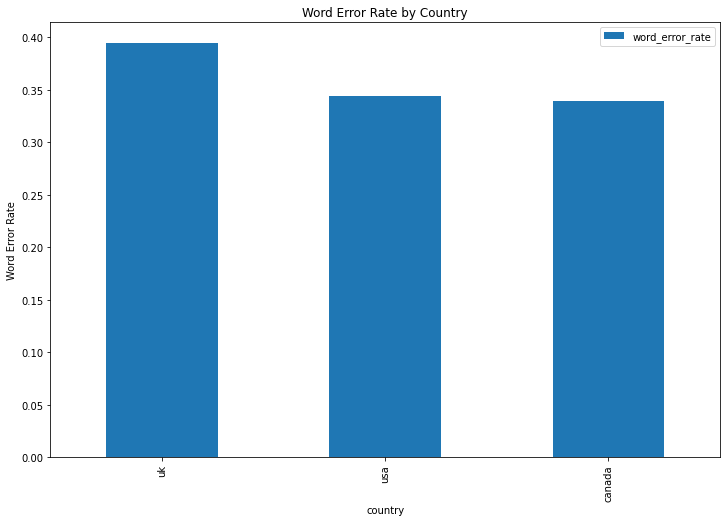

In [162]:
metricframe_country.by_group.sort_values(by="word_error_rate", ascending=False).plot(kind="bar", y="word_error_rate", ylabel="Word Error Rate", title="Word Error Rate by Country", figsize=[12,8])

Next, let's explore how our system performs with respect to `sex` of the speaker. Similar to what we did for `country`, we create another `MetricFrame` except passing in the `sex` column as our `sensitive_features`.

In [16]:
metricframe_sex = MetricFrame(
    metrics=fairness_metrics,
    y_true=filtered_df.loc[:, "ground_truth_text"],
    y_pred=filtered_df.loc[:, "predicted_text"],
    sensitive_features=filtered_df.loc[:, "sex"]
    
)

In [17]:
display(metricframe_sex.by_group[["count", "word_error_rate"]])
display(metricframe_sex.difference())

,count,word_error_rate
sex,,
female,225,0.318261
male,257,0.378503


count                                  32
word_error_rate                  0.060242
word_error_rate_abs_disparity    0.060242
word_error_rate_rel_disparity    0.120485
dtype: object

In our `sex`-based analysis, we see there is a `0.06` difference in the *WER* between `male` and `female` speakers. If we added uncertainty quantification, such as *confidence intervals*, to our analysis, we could perform statistical tests to determine if the difference is statistically significant or not.

<AxesSubplot:title={'center':'Word Error Rate by Sex'}, xlabel='sex', ylabel='Word Error Rate'>

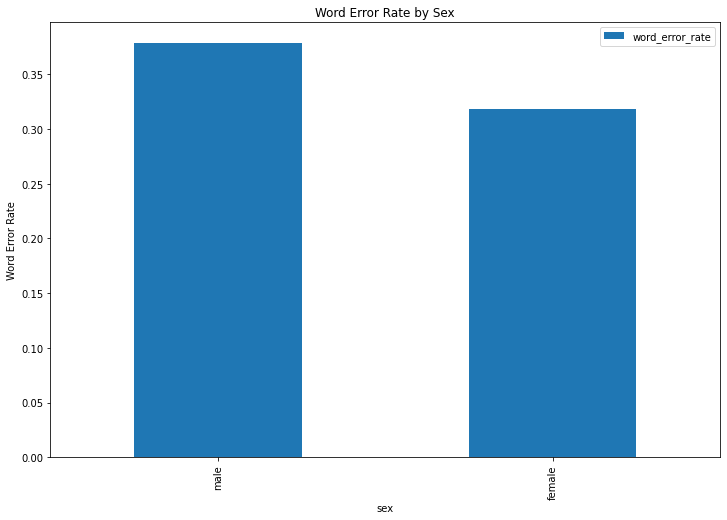

In [163]:
metricframe_sex.by_group.sort_values(by="word_error_rate", ascending=False).plot(kind="bar", y="word_error_rate", ylabel="Word Error Rate", title="Word Error Rate by Sex", figsize=[12,8])

### Intersectional Analysis

One key aspect to remember when performing a fairness analysis is to explore the intersection of different groups. For this final analysis, we would look at groups at the intersection of `country` and `sex`.

In particular, we are interested in seeing the `word_error_rate difference` by `sex` for each `country`. That is, we want to compare the `WER difference` between `Canada male` and `Canada female` to the `WER difference` between `males` and `females` of the other two countries.

When we instantiate our `MetricFrame` this time, we pass in the `country` column as a `control_feature`. Now when we call the `difference` method for our `MetricFrame`, it will compute the `WER difference` for `male` and `female` by each country.

In [20]:
# Make country a control feature
metricframe_country_sex_control = MetricFrame(
    metrics=fairness_metrics,
    y_true=filtered_df.loc[:, "ground_truth_text"],
    y_pred=filtered_df.loc[:, "predicted_text"],
    sensitive_features=filtered_df.loc[:, "sex"],
    control_features=filtered_df.loc[:, "country"]
        
)

In [164]:
display(metricframe_country_sex_control.difference())

,count,word_error_rate,word_error_rate_abs_disparity,word_error_rate_rel_disparity
country,,,,
canada,10,0.001326,0.001326,0.002652
uk,17,0.095543,0.095543,0.191086
usa,5,0.058616,0.058616,0.117232


If we call the `by_group` attribute, we get the `MultiIndex DataFrame` showing the `count` and `word_error_rate` for each intersectional group.

In [165]:
display(metricframe_country_sex_control.by_group[["count", "word_error_rate"]])

count word_error_rate
country sex                         
canada  female    17        0.338448
        male      27        0.339775
uk      female    24        0.333937
        male      41         0.42948
usa     female   184        0.314745
        male     189        0.373361

Now, let's explore our `word_error_rate` disparity by `sex` within each country. Plotting the absolute `word_error_rates` for each intersectional group shows us that the disparity betwen `UK male` and `UK female` is noticeably larger compared to the other countries.

In [46]:
group_metrics = metricframe_country_sex_control.by_group[["count", "word_error_rate"]]

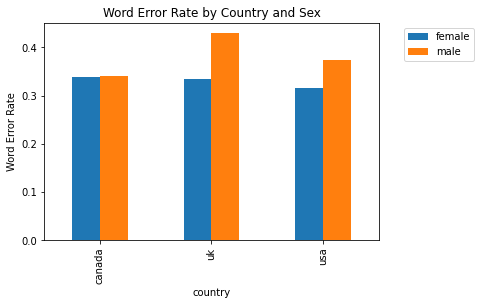

In [84]:
group_metrics["word_error_rate"].unstack(level=-1).plot(
    kind="bar",
    ylabel="Word Error Rate",
    title="Word Error Rate by Country and Sex")
plt.legend(bbox_to_anchor=(1.3,1))

In [184]:
def plot_controlled_features(multiindexframe, title, xaxis, yaxis, order):
    """
    Helper function to plot the visualization for the 
    """
    plt.figure(figsize=[12,8])
    disagg_metrics = multiindexframe["word_error_rate"].unstack(level=0).loc[:, order].to_dict()
    male_scatter = []
    female_scatter = []
    countries = disagg_metrics.keys()
    for country, sex_wer in disagg_metrics.items():
        male_point, female_point = sex_wer.get("male"), sex_wer.get("female")
        plt.vlines(country, female_point, male_point, linestyles="dashed", alpha=0.45)
        #Need to pair X-axis (Country) with each point
        male_scatter.append(male_point)
        female_scatter.append(female_point)
    plt.scatter(countries, male_scatter, marker="^", color="b", label="Male")
    plt.scatter(countries, female_scatter, marker="s", color="r", label="Female")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)

We can also visualize the relative disparity by `sex` for each `country`. From these plots, we see the difference between `UK male` and `UK female` is ~0.09. This is larger than the disparity between `US male` and `US female` (0.06) and the disparity between `Canada male` and `Canada female` (> 0.01).

c:\users\v-manandi\anaconda3\envs\facelearn\lib\site-packages\fairlearn\metrics\_metric_frame.py:478: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  return (self.by_group - subtrahend).abs().max(level=self.control_levels)


<AxesSubplot:title={'center':'Word Error Rate between Sex by Country'}, xlabel='country'>

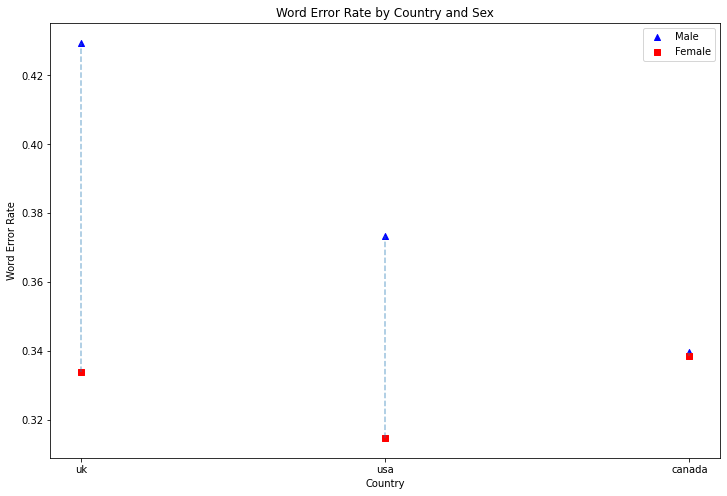

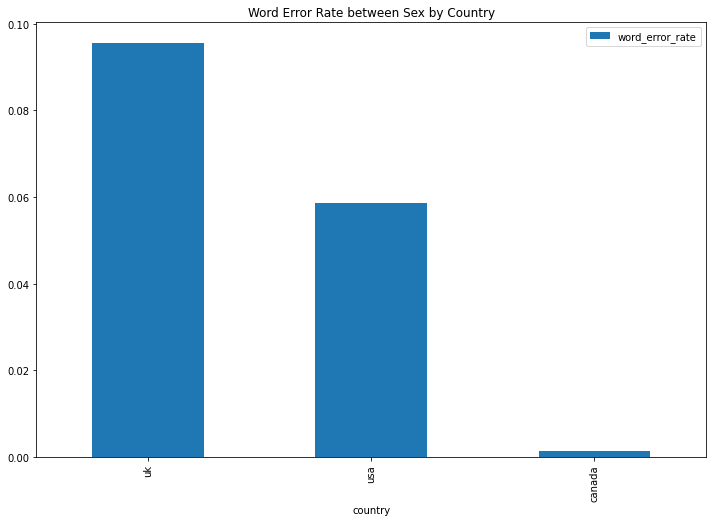

In [185]:
plot_controlled_features(group_metrics,
                         "Word Error Rate by Country and Sex",
                         "Country",
                         "Word Error Rate",
                        order=["uk", "usa", "canada"])

metricframe_country_sex_control.difference().sort_values(by="word_error_rate", ascending=False).plot(
    kind="bar",
    y="word_error_rate",
    title="Word Error Rate between Sex by Country",
    figsize=[12,8])

# Conclusion

With this fairness assessment, we explored how `country` and `sex` affect the quality of a speech-to-text transcription in three English-speaking countries. Through an intersectional analysis, we found a higher disparity in the *quality-of-service* between `UK male` and `UK female` compared to males and females of other countries.